In [9]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'png' 

pio.templates.default = "plotly_white"

# load the dataset
df = pd.read_csv("chatgpt_reviews.csv")

df.head()

,Review Id,Review,Ratings,Review Date
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,2024-08-23 19:30:05
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,2024-08-23 19:28:18
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,2024-08-23 19:22:59
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,2024-08-23 19:20:50
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,2024-08-23 19:20:39


In [10]:
df.isnull().sum()

Review Id      0
Review         6
Ratings        0
Review Date    0
dtype: int64

In [11]:
df['Review'] = df['Review'].astype(str).fillna('')

In [12]:
from textblob import TextBlob

# function to determine sentiment polarity
def get_sentiment(review):
    sentiment = TextBlob(review).sentiment.polarity
    if sentiment > 0:
        return 'Positive'
    elif sentiment < 0:
        return 'Negative'
    else:
        return 'Neutral'

# apply sentiment analysis
df['Sentiment'] = df['Review'].apply(get_sentiment)

sentiment_distribution = df['Sentiment'].value_counts()

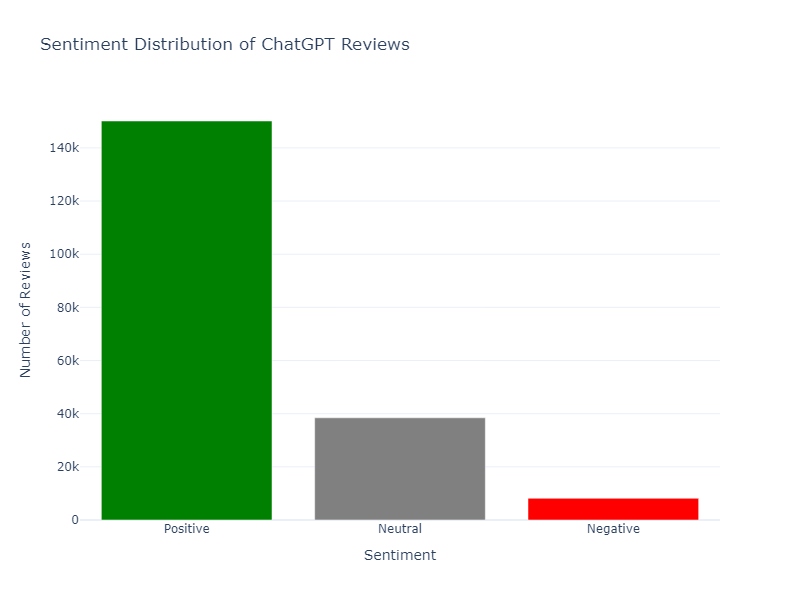

In [13]:
import plotly.io as pio
pio.renderers.default = 'svg'

fig = go.Figure(data=[go.Bar(
    x=sentiment_distribution.index,
    y=sentiment_distribution.values,
    marker_color=['green', 'gray', 'red'],
)])

fig.update_layout(
    title='Sentiment Distribution of ChatGPT Reviews',
    xaxis_title='Sentiment',
    yaxis_title='Number of Reviews',
    width=800,
    height=600
)
fig.write_image("sentiment_distribution.png")

# Display the saved image
from IPython.display import Image
Image(filename="sentiment_distribution.png")

#fig.show()

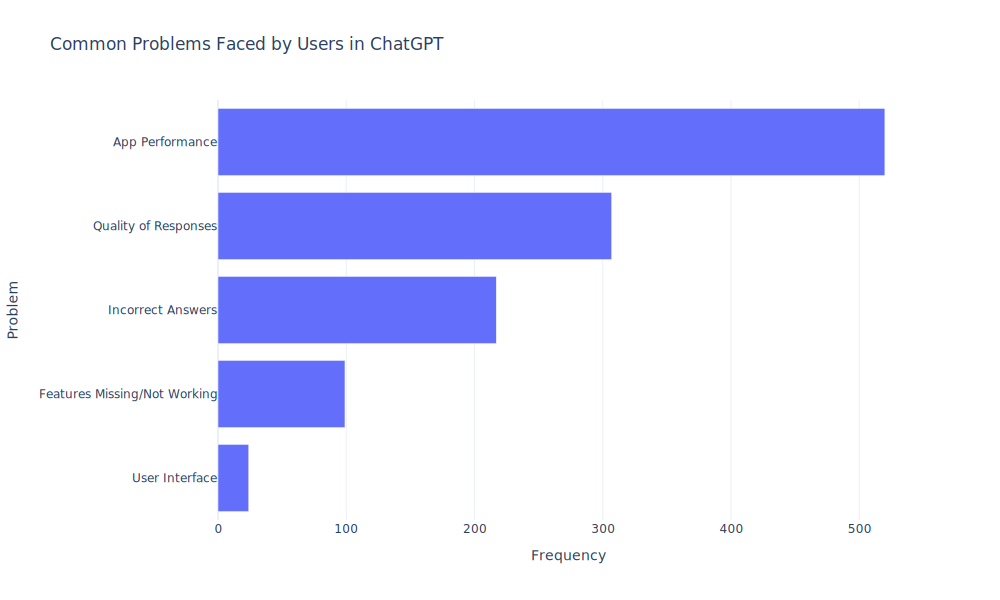

In [14]:


# Step 1: Define negative reviews
negative_reviews = df[df['Sentiment'] == 'Negative']['Review']


# Step 2: Keywords to extract from reviews
keywords = ['wrong answer', 'slow', 'crash', 'not working', 'difficult to use', 
            'confusing', 'loading', 'glitch', 'useless', 'terrible']

# Step 3: Count occurrences of keywords in reviews
phrase_counts = Counter(phrase for review in negative_reviews 
                        for phrase in keywords if phrase in review.lower())

# Convert to a list of tuples
phrase_freq_neg = list(phrase_counts.items())
# grouping similar phrases into broader problem categories
problem_keywords = {
    'Incorrect Answers': ['wrong answer', 'gives wrong', 'incorrect', 'inaccurate', 'wrong'],
    'App Performance': ['slow', 'lag', 'crash', 'bug', 'freeze', 'loading', 'glitch', 'worst app', 'bad app', 'horrible', 'terrible'],
    'User Interface': ['interface', 'UI', 'difficult to use', 'confusing', 'layout'],
    'Features Missing/Not Working': ['feature missing', 'not working', 'missing', 'broken', 'not available'],
    'Quality of Responses': ['bad response', 'useless', 'poor quality', 'irrelevant', 'nonsense']
}

# initialize a dictionary to count problems
problem_counts = {key: 0 for key in problem_keywords.keys()}

# count occurrences of problem-related phrases in negative reviews
for phrase, count in phrase_freq_neg:
    for problem, keywords in problem_keywords.items():
        if any(keyword in phrase for keyword in keywords):
            problem_counts[problem] += count
            break

problem_df = pd.DataFrame(list(problem_counts.items()), columns=['Problem', 'Frequency'])

fig = px.bar(problem_df,
             x='Frequency',
             y='Problem',
             orientation='h', 
             title='Common Problems Faced by Users in ChatGPT',
             labels={'Problem': 'Problem', 'Frequency': 'Frequency'},
             width=1000,
             height=600)

fig.update_layout(
    plot_bgcolor='white',  
    paper_bgcolor='white', 
    xaxis_title='Frequency',
    yaxis_title='Problem',
    yaxis={'categoryorder':'total ascending'}  
)

fig.show()

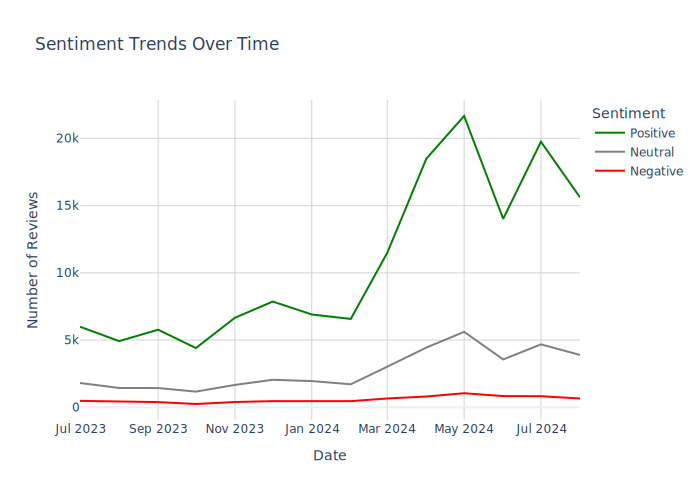

In [15]:
# convert 'Review Date' to datetime format
df['Review Date'] = pd.to_datetime(df['Review Date'])

# aggregate sentiment counts by date
sentiment_over_time = df.groupby([df['Review Date'].dt.to_period('M'), 'Sentiment']).size().unstack(fill_value=0)

# convert the period back to datetime for plotting
sentiment_over_time.index = sentiment_over_time.index.to_timestamp()

fig = go.Figure()

fig.add_trace(go.Scatter(x=sentiment_over_time.index, y=sentiment_over_time['Positive'],
                         mode='lines', name='Positive', line=dict(color='green')))
fig.add_trace(go.Scatter(x=sentiment_over_time.index, y=sentiment_over_time['Neutral'],
                         mode='lines', name='Neutral', line=dict(color='gray')))
fig.add_trace(go.Scatter(x=sentiment_over_time.index, y=sentiment_over_time['Negative'],
                         mode='lines', name='Negative', line=dict(color='red')))

fig.update_layout(
    title='Sentiment Trends Over Time',
    xaxis_title='Date',
    yaxis_title='Number of Reviews',
    plot_bgcolor='white',  
    paper_bgcolor='white',  
    legend_title_text='Sentiment',
    xaxis=dict(showgrid=True, gridcolor='lightgray'), 
    yaxis=dict(showgrid=True, gridcolor='lightgray')
)

fig.show()